In [1]:
!pip3 install sentencepiece
!pip3 install tf-sentencepiece
!pip3 install matplotlib
#!pip3 install tqdm
#!pip install tensorflow==1.13.1

     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 2.4MB 2.8MB/s 


In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
os.chdir(gitDir + "data/")
print(os.listdir("."))

#sys.path.insert(0,gitDir + "data")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['Kaggle Amazon Fine Food.ipynb', 'Organic Dataset.ipynb', 'cache', 'Amazon Reviews.ipynb', '__pycache__', 'amazon_multilingual.py', 'old', 'Amazon Multilingual.ipynb', 'load_dataset.py', 'tmp.ipynb']


In [3]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import numpy as np
import tf_sentencepiece

import load_dataset
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import glob, time, datetime
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import f1_score

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

W0610 08:31:14.461953 140077669390208 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1
Version:  1.13.1
Eager mode:  False
Hub version:  0.4.0
GPU is available


## create graph

In [0]:
class Model:
    def __init__(self, data_X, data_Y, architecture, xling=None):
        self.n_class = 39
        self.architecture = architecture
        if xling is None:
          print("Downloading xling...")
          self.xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling-many/1", trainable=False) 
        else:
          self.xling = xling
        self.data_X = data_X
        self.data_Y = data_Y
        self.create_architecture(data_X, data_Y)
        
        
    def create_architecture(self, data_X, data_Y):
        #y_hot = tf.one_hot(data_Y, depth=self.n_class)
        self.logits = self.forward(data_X)
        
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.logits))
        self.train_op = tf.train.AdamOptimizer(learning_rate=0.0005, epsilon=1e-3).minimize(self.loss) #learning_rate=0.0001, 

        self.predictions = tf.argmax(self.logits, 1)
        self.labels = data_Y
        #self.acc, self.acc_op = tf.metrics.accuracy(labels=data_Y, predictions=self.predictions)
        
        #a = tf.cast(self.predictions, tf.float64)
        self.accuracy = tf.reduce_mean( tf.cast(tf.equal(self.predictions, tf.cast(data_Y, tf.int64)), tf.float32) )
        
    def forward(self, X):
        output = self.xling(X)
        
        for x in self.architecture:
          if x == "bn":
            output = tf.layers.batch_normalization(output, training=True)
          elif x == "relu" or x == "r":
            output = tf.nn.relu(output)
          elif x == "dropout" or x == "d":
            output = tf.layers.dropout(output)
          else:
            output = tf.layers.dense(output, x)
            
        output = tf.layers.dense(output, self.n_class, name="final_output_prediction")
        
        return output

# train

In [0]:
def trainModel(model, params):

  init_op = tf.group([tf.local_variables_initializer(), tf.global_variables_initializer(), tf.tables_initializer()])
  sess = tf.Session()
  sess.run(init_op)

  loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
  loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = [], [], [], [], [], []
  train_predictions, train_labels, val_predictions, val_labels = [], [], [], []

  for epoch in tqdm(range(params["epochs"])):
    #print('\nEpoch: {}'.format(epoch + 1))
    train_loss, train_accuracy = 0, 0
    val_loss, val_accuracy = 0, 0  
    counter = 0

    sess.run(train_iterator)

    try:
      with tqdm(total = params["trainexamples"]) as pbar:
        while True:
          _, a, l, predictions, labels = sess.run([model.train_op, model.accuracy, model.loss, model.predictions, model.labels])
          #print(a,l)
          
          if l >0 and l < 15:
            pass
          else:
            print(l)
            print(counter)
            print(sess.run(model.data_X))
            #print(tf.print(model.data_Y))
                  
                  
          train_loss += l
          train_accuracy += a
          loss_hist.append(l)
          acc_hist.append(a)
          pbar.set_postfix_str((l, a))
          pbar.update(params["batchSize"])
          
          train_predictions.extend(predictions)
          train_labels.extend(labels)
          
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    loss_hist_epoch.append(train_loss / counter)
    acc_hist_epoch.append(train_accuracy / counter)
    train_f1 = f1_score(train_labels, train_predictions, average="micro")
    f1_train_epoch.append(train_f1)
    #print('\nEpoch: {}'.format(epoch + 1))
    


    # Validation
    counter = 0
    sess.run(val_iterator) 
    try:
      with tqdm(total = params["trainexamples"]) as pbar:
        while True:
          a, l, p, labels = sess.run([model.accuracy, model.loss, model.predictions, model.labels])
          val_loss += l
          val_accuracy += a
          val_loss_hist.append(l)
          val_acc_hist.append(a)
          pbar.set_postfix_str((l, a))
          pbar.update(params["batchSize"])
          
          val_predictions.extend(p)
          val_labels.extend(labels)
          
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    val_loss_hist_epoch.append(val_loss / counter)
    val_acc_hist_epoch.append(val_accuracy / counter)
    val_f1 = f1_score(val_labels, val_predictions, average="micro")
    f1_val_epoch.append(val_f1)
    print('\tEpoch {}: train_loss: {:.4f}, train_acc: {:.4f}, train_micro-f1: {:.4f} || val_loss: {:.4f}, val_acc: {:.4f}, val_micro-f1: {:.4f}'.format(epoch + 1, loss_hist_epoch[-1], acc_hist_epoch[-1], train_f1, val_loss_hist_epoch[-1], val_acc_hist_epoch[-1], val_f1))
    
  
  sess.close()
  return loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch , val_acc_hist_epoch, f1_train_epoch, f1_val_epoch

In [0]:
import matplotlib.pyplot as plt
import datetime, os

def plotResults(x1, label1, x2, label2, title, path, architecture):
  plt.plot(x1, label=label1)
  plt.plot(x2, label=label2)
  plt.legend()
  plt.title(title)
  #plt.ylim(0,1)
  figpath = path + title + ".png"
  #figpath = figpath.replace()
  #print(figpath)
  plt.savefig(figpath)
  plt.show()
  
  np.save(path + str(architecture) + label1 + ".npy", x1)
  np.save(path + str(architecture) + label2 + ".npy", x2)

saving to: /content/gdrive/My Drive/nlp/blobs/2019-06-10_08-31-17/
./cache/amazon_reviews_multilingual_UK_v1_00.tsv.shuffled.csv already exists. Using cached data
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


W0610 08:31:18.517342 140077669390208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


./cache/amazon_reviews_multilingual_DE_v1_00.tsv.shuffled.csv already exists. Using cached data
Instructions for updating:
Colocations handled automatically by placer.


W0610 08:31:18.578986 140077669390208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:358: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0610 08:31:41.538365 140077669390208 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.dropout instead.


W0610 08:31:42.461007 140077669390208 deprecation.py:323] From <ipython-input-4-992e1987f3c5>:38: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use keras.layers.dense instead.


W0610 08:31:42.469798 140077669390208 deprecation.py:323] From <ipython-input-4-992e1987f3c5>:40: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.cast instead.


W0610 08:31:42.977323 140077669390208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0610 08:31:43.088428 140077669390208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:199: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[True, 'dropout', 50, 'dropout']


	Epoch 1: train_loss: 2.3748, train_acc: 0.3775, train_micro-f1: 0.3775 || val_loss: 1.3492, val_acc: 0.6878, val_micro-f1: 0.6878


	Epoch 2: train_loss: 1.0396, train_acc: 0.6738, train_micro-f1: 0.5257 || val_loss: 0.9224, val_acc: 0.7301, val_micro-f1: 0.7090


	Epoch 3: train_loss: 0.8489, train_acc: 0.7188, train_micro-f1: 0.5901 || val_loss: 0.8218, val_acc: 0.7626, val_micro-f1: 0.7269


	Epoch 4: train_loss: 0.7704, train_acc: 0.7432, train_micro-f1: 0.6283 || val_loss: 0.7736, val_acc: 0.7749, val_micro-f1: 0.7389


	Epoch 5: train_loss: 0.7157, train_acc: 0.7582, train_micro-f1: 0.6543 || val_loss: 0.7434, val_acc: 0.7776, val_micro-f1: 0.7466


	Epoch 6: train_loss: 0.6668, train_acc: 0.7720, train_micro-f1: 0.6739 || val_loss: 0.7382, val_acc: 0.7803, val_micro-f1: 0.7522


	Epoch 7: train_loss: 0.6185, train_acc: 0.7882, train_micro-f1: 0.6903 || val_loss: 0.7468, val_acc: 0.7848, val_micro-f1: 0.7569


	Epoch 8: train_loss: 0.5713, train_acc: 0.8033, train_micro-f1: 0.7044 || val_loss: 0.7514, val_acc: 0.7782, val_micro-f1: 0.7595


	Epoch 9: train_loss: 0.5220, train_acc: 0.8211, train_micro-f1: 0.7174 || val_loss: 0.7828, val_acc: 0.7809, val_micro-f1: 0.7619


	Epoch 10: train_loss: 0.4726, train_acc: 0.8415, train_micro-f1: 0.7298 || val_loss: 0.8176, val_acc: 0.7810, val_micro-f1: 0.7638

CPU times: user 43min 54s, sys: 13min 30s, total: 57min 24s
Wall time: 1h 7min 11s
	 [2.374846759209266, 1.039564668520903, 0.8489104249538519, 0.7703597542567131, 0.7157424697509178, 0.6668345723396693, 0.6185250242551168, 0.5712644659555876, 0.5220062997096624, 0.4725710888703664] [0.3774939903846154, 0.673828125, 0.7188301282051283, 0.7431690705128206, 0.7582331730769231, 0.7719851762820513, 0.7882211538461539, 0.8033453525641026, 0.8211438301282051, 0.8415064102564103] 
	 [1.3492141717519515, 0.9224234143892924, 0.8217785865832598, 0.7735618062508411, 0.7433503465774732, 0.7382141648194729, 0.7467862382913247, 0.7514284604634994, 0.7828246935819968, 0.8176331406984574] [0.6878305288461538, 0.7301482371794872, 0.7626001602564103, 0.7748597756410256, 0.7775841346153847, 0.7803485576923077, 0.784775641025641, 0.7781951121794872, 0.780869391025641, 0.7810

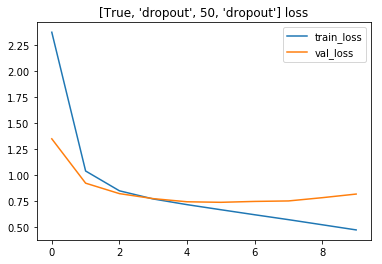

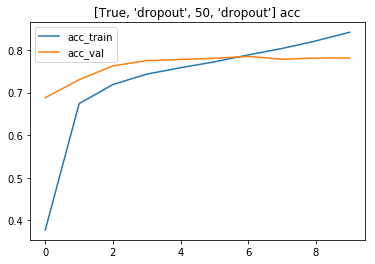

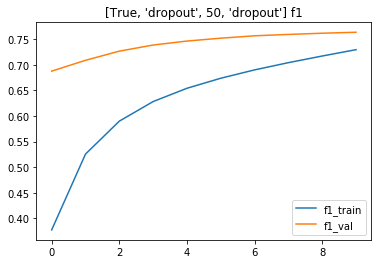

In [7]:
params = {}
params["trainData"] = "UK"
params["testData"] = "DE"
params["epochs"] = 10
params["batchSize"] = 512
params["trainexamples"] = 1000 * 100
params["savelog"] = True


#[True], 
architectures = [ [True,"dropout",50,"dropout"] ] #, [True,"dropout",50,"dropout"]

path="./"
if params["savelog"]==True:
  path = '/content/gdrive/My Drive/nlp/blobs/' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "/"
  os.mkdir(path)
  print("saving to:", path)

  f = open(path + "info.txt", "w")
  f.write(str(params)+"\n architectures: "+str(architectures))
  f.close()
  
loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch = [],[],[],[]

for a in architectures:
  tf.reset_default_graph()
  dataset_train = load_dataset.getData(params["trainData"], shuffle=True, batchsize=params["batchSize"])
  dataset_val = load_dataset.getData(params["testData"], shuffle=False, batchsize=params["batchSize"])
  
  dataset_train = dataset_train.take(int(params["trainexamples"]/params["batchSize"]))
  dataset_val = dataset_val.take(int(params["trainexamples"]/params["batchSize"]))
  
  iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
  train_iterator = iterator.make_initializer(dataset_train)
  val_iterator = iterator.make_initializer(dataset_val)
  text_input, label = iterator.get_next()
  
  xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling/en-de/1", trainable=a[0])
  model = Model(text_input, label, a[1:], xling)
  print(str(a))
  %time loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = trainModel(model, params)
  print("\t", loss_hist_epoch, acc_hist_epoch, "\n\t", val_loss_hist_epoch, val_acc_hist_epoch)
  plotResults(loss_hist_epoch, "train_loss", val_loss_hist_epoch, "val_loss", str(a)+" loss", path, a)
  plotResults(acc_hist_epoch, "acc_train", val_acc_hist_epoch, "acc_val", str(a)+ " acc", path, a)
  plotResults(f1_train_epoch, "f1_train", f1_val_epoch, "f1_val", str(a) + " f1", path, a)
  
  tf.reset_default_graph()
  del model, xling, dataset_train, dataset_val, iterator,train_iterator,val_iterator,text_input, label
  tf.reset_default_graph()

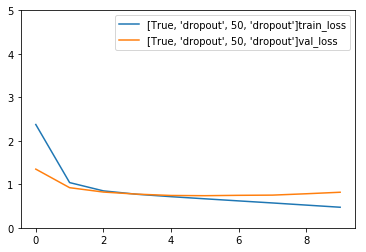

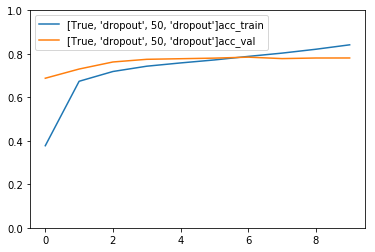

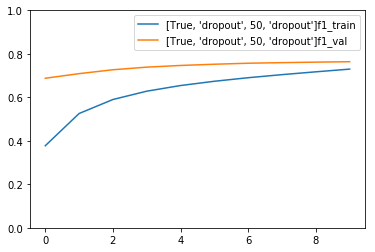

In [8]:
for f in glob.glob(path+"*loss.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,5)
plt.savefig(path+"allloss.png")
plt.show()

for f in glob.glob(path+"*acc*.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,1)
plt.savefig(path+"allacc.png")
plt.show()

for f in glob.glob(path+"*f1*.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,1)
plt.savefig(path+"allf1.png")
plt.show()